In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import os
import pandas as pd

from load_data import BiopsyDataset, DATA_DIR, TRANSFORMS, P53_CLASS_NAMES
from resnet import ResNetModel, ResNetModelDoubleBinary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Device: {}".format(device))

C:\Users\321lu\AppData\Local\Temp\ipykernel_37100\1258852746.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Device: cuda
Device: cuda


In [2]:
labels_df = pd.read_csv(os.path.join(DATA_DIR, 'biopsy_labels_anon_s1.0.csv'))
display(labels_df)

,id,label
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
1527,1527,2
1528,1528,2
1529,1529,0
1530,1530,0


In [3]:
test_transform = TRANSFORMS["normalize"]

In [4]:
# checkpoint_path = "models/resnet_resize-epoch14-acc0.70.ckpt"
checkpoint_path = "models/resnet_s1024-epoch31-acc0.69.ckpt"
model = ResNetModel.load_from_checkpoint(checkpoint_path, num_classes=len(P53_CLASS_NAMES))
model.eval()

# The non-augmented models seems to have better heatmaps
checkpoint_path_db = "models/acc0.72_epoch44_s1024_end-to-end_double-binary.ckpt"   # 77 on test set, 76 on bolero
checkpoint_path_db = "models/acc0.67_epoch39_s1024_end-to-end_double-binary.ckpt" # best on test set (80), 83 on bolero, 87 with .1,.1
# checkpoint_path_db = "models/acc0.69_epoch39_s1024_end-to-end_double-binary.ckpt" # more robust (augmented) model (81 on test, 85 on bolero)
# checkpoint_path_db = "models/acc0.66_epoch37_s1024_end-to-end_double-binary.ckpt" # more robust (augmented) model (83 on test, 80 on bolero, 87 with .15,.15)
model_db = ResNetModelDoubleBinary.load_from_checkpoint(checkpoint_path_db)
model_db.eval()
pass

MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
SUBMODEL: ResNetModelDoubleBinary
MODEL ARGS: see_opposite_class_data=normal


In [72]:
def calc_heatmap(idx):
    img = plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{idx}.png')) # Shape: (H, W, 3)
    img_size = 1024
    img = torch.tensor(img).permute(2, 0, 1).to(device) # Shape: (3, H, W)
    # Resize image
    img = torch.nn.functional.interpolate(img.unsqueeze(0), size=(img_size, img_size), mode='bilinear', align_corners=False)
    img = test_transform(img) # Shape: (1, 3, H, W)

    # Do the same as above but this time with overlap between the patches, to make the heatmap smoother
    # So for example with patch size 256, but step size 64, we will have 16 times more patches
    patch_size = 128
    step_size = 64

    # Pad the image to accommodate the step size when sliding the patches
    pad = (patch_size - step_size)
    img = torch.nn.functional.pad(img, (pad, 0, pad, 0)) # the order is left, right, top, bottom
    WT_img = torch.zeros(3, img_size, img_size)
    img_size = img.shape[-1]
    # Fill with mean color of the image
    pixels = img.squeeze().cpu()
    WT_img[0] = pixels[0].mean()
    WT_img[1] = pixels[1].mean()
    WT_img[2] = pixels[2].mean()
    WT_img = torch.nn.functional.pad(WT_img, (pad, 0, pad, 0))

    patches_added = WT_img.unsqueeze(0).clone() # Shape: (1, 3, img_size, img_size)
    steps = img_size // step_size
    middle = img_size // 2 - patch_size // 2
    patches_added = patches_added.repeat(steps, steps, 1, 1, 1)
    for i in range(0, img_size, step_size):
        for j in range(0, img_size, step_size):
            # Place patch in the middle of patches_added
            patch = img[:, :, i:i+patch_size, j:j+patch_size]
            w, h = patch.shape[-2], patch.shape[-1] # This is necessary because the patch can be smaller than patch_size at the edges
            patches_added[i // step_size, j // step_size, :, middle:middle+w, middle:middle+h] = img[:, :, i:i+patch_size, j:j+patch_size]

    # Reshape the tensor to (B, 3, img_size, img_size)
    patches_added = patches_added.view(-1, 3, img_size, img_size)

    # Crop to the original image size
    patches_added = patches_added[:, :, pad:, pad:]

    # Get the model output for each image
    diff = torch.zeros(patches_added.shape[0], 2)
    # for i in tqdm(range(patches_added.shape[0]), desc="Generating Heatmap"): # necessary for CUDA memory
    for i in range(patches_added.shape[0]): # necessary for CUDA memory
        current_img = patches_added[i].unsqueeze(0).to(device)
        with torch.no_grad():
            diff[i] = model_db(current_img).cpu().detach().squeeze()
    # Normalize the difference
    diff[:, 0] = (diff[:, 0] - diff[:, 0].min())
    diff[:, 1] = (diff[:, 1] - diff[:, 1].min())

    # Make heatmap as grid of patch outputs
    overexpression_heatmap = np.zeros((steps, steps))
    nullmutation_heatmap = np.zeros((steps, steps))

    # Make a mask to keep track of the number of patches that overlap in each pixel
    mask = np.zeros((steps, steps))

    steps_per_patch = patch_size // step_size
    for i in range(diff.shape[0]):
        row = i // steps
        col = i % steps
        overexpression_heatmap[row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 0].item()
        nullmutation_heatmap[row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 1].item()
        mask[row:row+steps_per_patch, col:col+steps_per_patch] += 1

    # Normalize the img by dividing by the mask
    overexpression_heatmap /= mask
    nullmutation_heatmap /= mask

    # Crop to the original image size
    pad_steps = pad // step_size
    overexpression_heatmap = overexpression_heatmap[pad_steps:, pad_steps:]
    nullmutation_heatmap = nullmutation_heatmap[pad_steps:, pad_steps:]

    return overexpression_heatmap, nullmutation_heatmap


def plot_heatmap(img, overexpression_heatmap, nullmutation_heatmap, mask=None):

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original image")
    # Overlay the heatmap on the image
    ax[1].imshow(img)
    # Rescale the heatmap to the image size
    overexpression_heatmap = cv2.resize(overexpression_heatmap, (img.shape[1], img.shape[0]), 
                                        # interpolation=cv2.INTER_NEAREST
                                        )
    ax[1].imshow(overexpression_heatmap, alpha=0.3, cmap='jet', vmin=0, 
                 vmax=1
                 )
    ax[1].set_title("Overexpression heatmap")

    # If mask is provided, draw its contours on the null mutation heatmap
    if mask is not None:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,0,0), 5)

    ax[2].imshow(img)
    nullmutation_heatmap = cv2.resize(nullmutation_heatmap, (img.shape[1], img.shape[0]), 
                                    #   interpolation=cv2.INTER_NEAREST
                                      )
    ax[2].imshow(nullmutation_heatmap, alpha=0.3, cmap='jet', vmin=0, 
                 vmax=1
                 )
    ax[2].set_title("Null mutation heatmap")

    plt.show()

In [ ]:
# DEMO
# idx = 946
# label = labels_df.loc[idx, 'label']
# print(label)
# overexpression_heatmap, nullmutation_heatmap = calc_heatmap(idx)
# img = plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{idx}.png'))
# plot_heatmap(img, overexpression_heatmap, nullmutation_heatmap)

In [6]:
save_dir = os.path.join(DATA_DIR, "heatmaps")
os.makedirs(save_dir, exist_ok=True)
# Total is all labels that are not 0
abnormal_labels = labels_df[labels_df["label"] != 0]
for idx, row in tqdm(abnormal_labels.iterrows(), desc="Generating heatmaps", total=len(abnormal_labels)):
    label = row["label"]
    if label == 0: # no need to get heatmaps for wildtype
        continue
    if os.path.exists(os.path.join(save_dir, f"{idx}.png")):
        continue

    overexpression_heatmap, nullmutation_heatmap = calc_heatmap(idx)
    # Make RGB heatmap with overexpression in red and null mutation in blue and save to save_dir
    heatmap = np.zeros((overexpression_heatmap.shape[0], overexpression_heatmap.shape[1], 3))
    heatmap[:, :, 2] = overexpression_heatmap
    heatmap[:, :, 0] = nullmutation_heatmap
    heatmap = (heatmap * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(save_dir, f"{idx}.png"), heatmap)

Generating heatmaps:   0%|          | 0/392 [00:00<?, ?it/s]

Index: 1101
Label: Overexpression


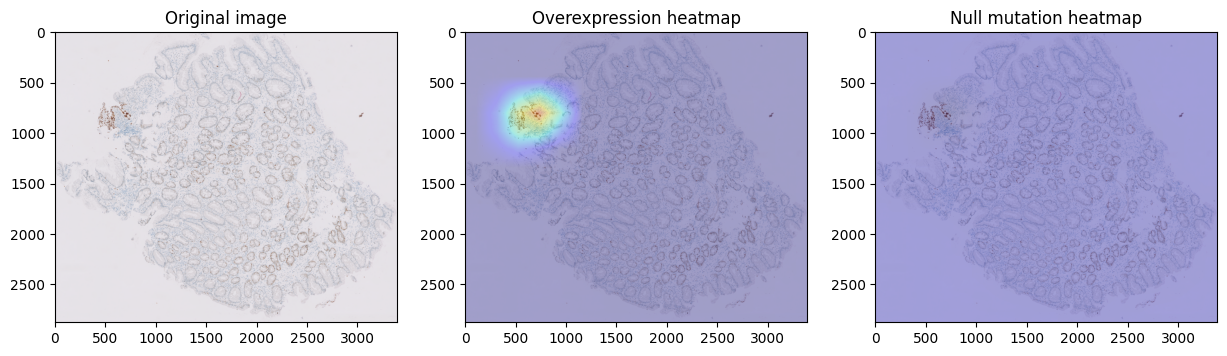

In [110]:
# Use one of the saved heatmaps to plot
# Take random idx from abnormal_labels
idx = abnormal_labels.sample().index[0]
print(f"Index: {idx}")
label = labels_df.loc[idx, "label"]
print(f"Label: {P53_CLASS_NAMES[label]}")
img = plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{idx}.png'))
heatmap = plt.imread(os.path.join(DATA_DIR, 'heatmaps', f'{idx}.png'))
overexpression_heatmap = heatmap[:, :, 0]
nullmutation_heatmap = heatmap[:, :, 2]

if label in [2,3]:
    nullmutation_heatmap /= nullmutation_heatmap.max()

mask = None
if label == 2:
    mask = plt.imread(os.path.join(DATA_DIR, 'masks', f'{idx}.png'))

plot_heatmap(img, overexpression_heatmap, nullmutation_heatmap, mask)

In [31]:
import json

with open(os.path.join(DATA_DIR, "biopsy_dims.json"), "r") as f:
    biopsy_dims = {int(k):tuple(v) for k,v in json.load(f).items()}

bag_latents = torch.load(os.path.join(DATA_DIR, "bag_latents_gs256_retccl.pt"))
non_empty_patch_indices = torch.load(os.path.join(DATA_DIR, "non_empty_patch_indices.pt"))

patch_size = 256

oe_patch_indices = {}
nm_patch_indices = {}

# Total is all labels that are not 0
abnormal_labels = labels_df[labels_df["label"] != 0]
for idx, row in tqdm(abnormal_labels.iterrows(), desc="Generating heatmaps", total=len(abnormal_labels)):
    label = row["label"]
    if label in [0]: # no need to get heatmaps for wildtype
        continue

    # print(f"Index: {idx}")
    # print(P53_CLASS_NAMES[label])

    h,w = biopsy_dims[idx]

    # Make width and height multiples of patch_size
    h,w = (max(round(h/patch_size), 1)*patch_size, 
            max(round(w/patch_size), 1)*patch_size)

    patch_rows = h // patch_size
    patch_cols = w // patch_size
    patch_grid = np.zeros((patch_rows, patch_cols, 2))

    # Load heatmap
    heatmap = plt.imread(os.path.join(DATA_DIR, 'heatmaps', f'{idx}.png'))
    heatmap = cv2.resize(heatmap, (w, h))
    overexpression_heatmap = heatmap[:, :, 0]
    nullmutation_heatmap = heatmap[:, :, 2]

    if label in [1,3]:
        overexpression_heatmap /= overexpression_heatmap.max()
    if label in [2,3]:
        nullmutation_heatmap /= nullmutation_heatmap.max()

    # Fill patch_grid with mean heatmap value for each patch
    for i in range(patch_rows):
        for j in range(patch_cols):
            patch = overexpression_heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patch_grid[i, j, 0] = np.quantile(patch, 0.90)
            patch = nullmutation_heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patch_grid[i, j, 1] = np.quantile(patch, 0.75)

    patch_flat = patch_grid.reshape(-1, 2)
    # Get the indices of the patches that are above the threshold (0.8 for overexpression, 0.4 for null mutation)
    if label in [1,3]:
        oe_patch_indices[idx] = np.where(patch_flat[:, 0] > 0.8)[0]
    if label in [2,3]:
        nm_patch_indices[idx] = np.where(patch_flat[:, 1] > 0.4)[0]

    # # Resize patch_grid for visualization
    # patch_img = cv2.resize(patch_grid, (w, h), interpolation=cv2.INTER_NEAREST)

    # # Plot both heatmaps
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # ax[0].imshow(overexpression_heatmap, cmap='jet', vmin=0, vmax=1)
    # ax[0].imshow(patch_img[:, :, 0], alpha=0.8, cmap='jet', vmin=0, vmax=1)
    # ax[0].set_title("Overexpression heatmap")


    # ax[1].imshow(nullmutation_heatmap, cmap='jet', vmin=0, vmax=1)
    # ax[1].imshow(patch_img[:, :, 1], alpha=0.8, cmap='jet', vmin=0, vmax=1)
    # ax[1].set_title("Null mutation heatmap")

    # if label in [2,3]:
    #     mask = plt.imread(os.path.join(DATA_DIR, 'masks', f'{idx}.png'))
    #     contour_img = np.zeros_like(mask)
    #     contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #     cv2.drawContours(contour_img, contours, -1, 1, 10)
    #     contour_img = cv2.resize(contour_img, (w, h), interpolation=cv2.INTER_NEAREST)[:,:,None].repeat(4, axis=-1)
    #     ax[1].imshow(contour_img)

    # # Draw white circle on every patch
    # for i in range(patch_rows):
    #     for j in range(patch_cols):
    #         for k in range(2):
    #             if patch_grid[i, j, k] < [0.8,0.4][k]:
    #                 continue
    #             x = j*patch_size + patch_size//2
    #             y = i*patch_size + patch_size//2
    #             ax[k].add_artist(plt.Circle((x, y), patch_size//3, color='black', fill=False, lw=1))

    # plt.show()

torch.save(oe_patch_indices, os.path.join(DATA_DIR, "oe_patch_indices_gs256.pt"))
torch.save(nm_patch_indices, os.path.join(DATA_DIR, "nm_patch_indices_gs256.pt"))

display(oe_patch_indices)
display(nm_patch_indices)

Generating heatmaps:   0%|          | 0/392 [00:00<?, ?it/s]

{8: array([19, 20, 21, 22, 26, 27, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 56, 61, 62, 73, 74],
       dtype=int64),
 9: array([ 5, 17, 22, 23, 27, 33, 34, 35, 36, 37, 43, 44, 45, 46],
       dtype=int64),
 11: array([21, 22, 23, 24, 25, 39, 40, 41, 42, 43], dtype=int64),
 12: array([ 95,  96,  97,  98,  99, 122, 123, 124], dtype=int64),
 14: array([15, 16, 18, 19, 25, 28, 29, 33, 40, 41, 42], dtype=int64),
 15: array([ 83,  84,  99, 100], dtype=int64),
 21: array([16, 17, 27, 28, 29, 38, 39, 40], dtype=int64),
 24: array([ 2,  3,  4,  5,  6,  7,  8, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 67, 68, 69, 70, 71, 72, 73, 74, 79, 80, 81, 82, 83, 84, 85, 92,
        93, 94, 95], dtype=int64),
 30: array([ 7,  8,  9, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30,
    

{0: array([ 7,  8, 15, 16, 17, 18], dtype=int64),
 1: array([ 55,  56,  93, 107, 108], dtype=int64),
 2: array([ 4,  5, 16, 17, 18, 19, 20, 23, 24, 25, 29, 30, 31, 43, 75, 76, 79,
        82, 83, 88, 89, 90, 92, 93, 96], dtype=int64),
 3: array([ 33,  82,  98,  99, 100, 101, 115, 116, 117, 118], dtype=int64),
 4: array([  4,  16,  17,  18,  19,  20,  22,  23,  24,  25,  29,  30,  36,
         37,  38,  39,  40,  43,  44,  53,  54,  65,  74,  75,  88,  89,
         90,  91,  92,  93,  95,  96, 103, 104, 105, 106, 107, 109, 110],
       dtype=int64),
 5: array([ 19,  20,  21,  23,  33,  34,  35,  37,  38,  51,  52,  99, 100,
        113, 114, 127, 128], dtype=int64),
 6: array([  9,  21,  22,  34,  35,  48,  61,  92,  93, 105, 106, 118, 119,
        132, 133, 134, 135, 136, 145, 146, 148], dtype=int64),
 7: array([ 7,  8, 18, 19, 29, 30, 41, 46, 51, 52, 57, 62, 63, 64, 68, 73, 74,
        78, 79, 89, 90], dtype=int64),
 19: array([ 52,  61,  62, 113], dtype=int64),
 26: array([ 3,  4, 15

In [4]:
bag_latents_1 = torch.load(os.path.join(DATA_DIR, "bag_latents_gs256_retccl__backup.pt"))
# bag_latents_2 = torch.load(os.path.join(DATA_DIR, "bag_latents_gs256_retccl.pt"))
bag_indices = torch.load(os.path.join(DATA_DIR, "non_empty_patch_indices_gs256.pt"))

bag_1_lengths = [len(bag) for bag in bag_latents_1.values()]
# bag_2_lengths = [len(bag) for bag in bag_latents_2.values()]
bag_idx_lengths = [len(bag) for bag in bag_indices.values()]
print(sum(bag_1_lengths), sum(bag_idx_lengths))
for i in range(len(bag_latents_1)):
    if len(bag_latents_1[i]) != len(bag_indices[i]):
        print(i, len(bag_latents_1[i]), len(bag_indices[i]))

print(len(bag_latents_1), bag_latents_1[0].shape)

87386 87386
1532 torch.Size([39, 1, 2048])


In [5]:
bag_latents_1 = torch.load(os.path.join(DATA_DIR, "bag_latents_gs256_retccl_relaxed.pt"))
bag_indices = torch.load(os.path.join(DATA_DIR, "non_empty_patch_indices_gs256_relaxed.pt"))

bag_1_lengths = [len(bag) for bag in bag_latents_1.values()]
bag_idx_lengths = [len(bag) for bag in bag_indices.values()]
print(sum(bag_1_lengths), sum(bag_idx_lengths))
for i in range(len(bag_latents_1)):
    if len(bag_latents_1[i]) != len(bag_indices[i]):
        print(i, len(bag_latents_1[i]), len(bag_indices[i]))

133565 135830
0 39 70
1 47 150
2 87 112
3 95 136
4 88 126
5 92 168
6 89 156
7 79 121
8 52 96
9 50 60
10 47 66
11 48 85
12 82 182
13 43 65
14 39 45
15 73 135
16 82 210
17 58 72
18 89 121
19 74 130
20 26 56
21 37 55
22 31 56
23 33 72
24 79 99
25 61 99
26 38 48
27 54 72
28 38 48
29 55 85
30 69 91
31 65 104
32 56 77
33 64 84
34 55 72
35 69 96
36 60 143
37 49 110
38 63 90
39 52 84
40 49 70
41 80 104
42 44 65
43 34 44
44 51 119
45 34 65
46 58 108
47 31 40
48 24 28
49 52 91
50 53 84
51 64 91
52 53 102
53 50 80
54 27 30
55 54 105
56 73 136
57 87 175
58 43 70
59 46 95
60 42 72
